#  Using Natural Language Processing for Sentiment Analysis

In [1]:
#Import libraries
import nltk
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

##  Importing DATA

In [2]:
#Import the data 
import pandas as pd
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])
df_train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
df_val.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


#### Data imported in the dataset and labeled as well

In [4]:
df = pd.concat([df_train,df_val])

Concating the Data as separate Test Data Present

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

In [6]:
print("DataFrame Shape",df.shape)

DataFrame Shape (18000, 2)


In [7]:
df.reset_index(inplace=True,drop=True)

<AxesSubplot:xlabel='label', ylabel='count'>

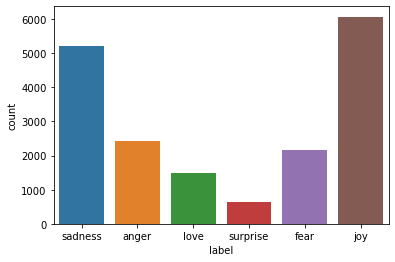

In [8]:
sns.countplot(df.label)

In [9]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [10]:
custom_encoder(df['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

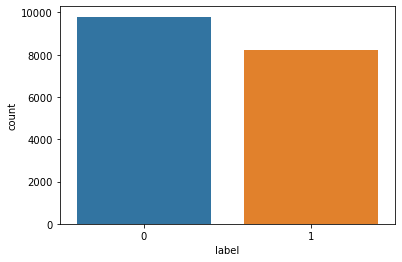

In [11]:
sns.countplot(df['label'])

In [12]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0


In [13]:
from nltk.stem import WordNetLemmatizer
#lemmatizer Object 
lm = WordNetLemmatizer()


In [14]:
from nltk.corpus import stopwords
def text_transformation(df_col):
# create empty list to append
    corpus = []
    for item in df_col:
        # to remove values except a-zA-Z 
        stripped = re.sub('[^a-zA-Z]',' ',str(item))
        # lower the Alphabet case
        stripped = stripped.lower()
        #split sentence into words
        stripped = stripped.split()

        stripped = [lm.lemmatize(word) for word in stripped if not word in set(stopwords.words('english'))]
        stripped = ' '.join(stripped)
        corpus.append(stripped)
    return corpus


In [15]:
corpus = text_transformation(df['text'])

In [16]:
type(corpus)

list

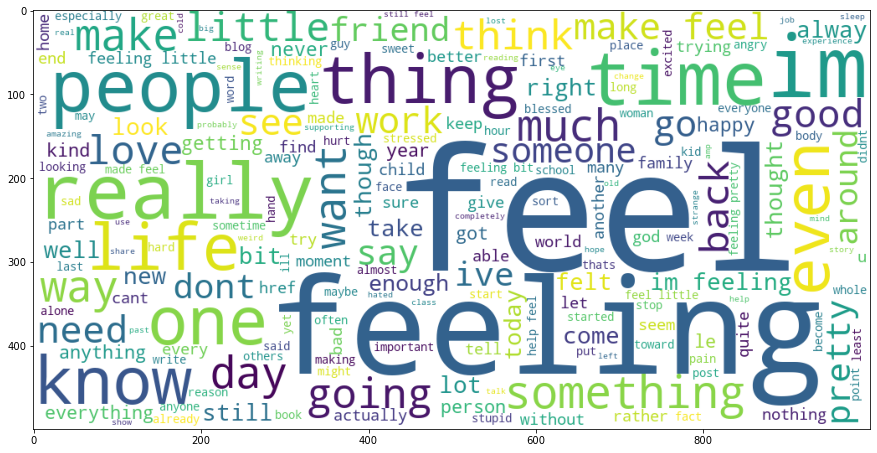

In [17]:
from wordcloud import WordCloud

words= ""
for row in corpus:
    for word in row:
        words+=" ".join(word)

word_cloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(words)
plt.figure(figsize=(15,8))
plt.imshow(word_cloud)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [19]:
#This makes intuitive sense; many job titles such as ‘data scientist’, ‘data engineer’, and ‘data analyst’ are 2 words long

## Using Bag Of Words

In [20]:
vectorizer = CountVectorizer(ngram_range=(1,2))
traindatacv = vectorizer.fit_transform(corpus)

In [21]:
X_train = traindatacv
Y_train = df.label
type(X_train)


scipy.sparse.csr.csr_matrix

In [22]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_features='sqrt',
                                      max_depth=None,
                                      n_estimators=1000,
                                      min_samples_split=5,
                                      min_samples_leaf=1,
                                      bootstrap='True')

#### Pipeline for our test Data

In [23]:
from sklearn.pipeline import Pipeline

In [24]:
pipeline = Pipeline(steps= [('cvector', CountVectorizer(ngram_range=(1,2))),
('model', RandomForestClassifier(max_features='sqrt',
                                      max_depth=None,
                                      n_estimators=1000,
                                      min_samples_split=5,
                                      min_samples_leaf=1,
                                      bootstrap='True'))])
#fit the pipeline model with the training data
pipeline.fit(corpus,Y_train)                     

Pipeline(steps=[('cvector', CountVectorizer(ngram_range=(1, 2))),
                ('model',
                 RandomForestClassifier(bootstrap='True', max_features='sqrt',
                                        min_samples_split=5,
                                        n_estimators=1000))])

In [25]:
file = open('sentiment_analysis_model.pkl', 'wb')

pickle.dump(pipeline, file)

# Test Data Transformation

In [26]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])

In [27]:
test_df.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [28]:
X_test,y_test = test_df.text,test_df.label

In [29]:
y_test.head()

0    sadness
1    sadness
2    sadness
3        joy
4    sadness
Name: label, dtype: object

In [30]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)


predictions = pipeline.predict(test_corpus)


In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print ('Final score = > ', accuracy_score(y_test,predictions))

Final score = >  0.9615


              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1080
           1       0.96      0.96      0.96       920

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



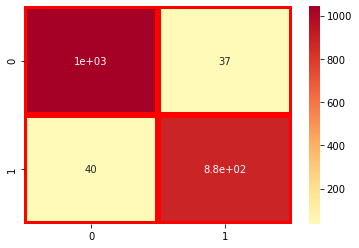

In [35]:
print(classification_report(y_test,predictions))

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test,predictions)
sns.heatmap(conf_mat,cmap="RdYlBu_r",annot=True,linewidths=5,linecolor='r',center=0)
plt.show()

In [36]:
#predictions_probability = rfc.predict_proba(testdata)
predictions_probability = pipeline.predict_proba(test_corpus)

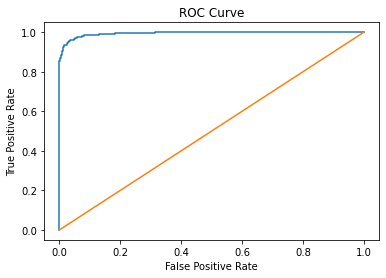

In [38]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Using TF-IDF

In [ ]:
#TFvectorizer = TfidfVectorizer(ngram_range = (1,2))
#traindatatf = TFvectorizer.fit_transform(corpus)

# custom Input

In [39]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [40]:
def sentiment_predictor(input):
    input = text_transformation(input)
    #transformed_input = cv.transform(input)
    #prediction = rfc.predict(transformed_input)
    prediction = pipeline.predict(input)
    expression_check(prediction)

In [41]:
input1 = ["I am feeling really good"]
input2 = ["I lost a new phone and it's not good."]
sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Positive Sentiment.
Input statement has Negative Sentiment.


In [42]:
input = text_transformation(input2)

In [43]:
prediction = pipeline.predict(input)